The dataset contains 12 features which can be used to predict heart failure - an event associated with CVD which is the number 1 cause of death globally. 

The study from which this dataset is derived claims that heart failure can be predicted from serum creatinine level and ejection fraction alone. Hence, these 2 will be major features of interest for the below analysis.

However, the study also includes features such as diabetes, anaemia etc. which are considered as major risk factors for CVD. Hence, this analysis will also try to derive insights regarding the significance of such factors and see if they play a role in predicting CVD as well. 

#### Import the necessary libraries

In [1476]:
# Import the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# Import the data processing and model evaluation libraries 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Import the models
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


#### Import the data

In [1477]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

#### Take a quick look at the data structure

In [1478]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Discrete - Age, time
Continuous - creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium
Binary - anaemia, diabetes, high blood pressure, sex, smoking, death event 


In [1479]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


There are no missing values.
There are no text based, sound based, date based values. 
Only 299 values, very small by ML standards. 

In [1480]:
# Summary of numerical attributes

df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C80E403808>,
      dtype=object)

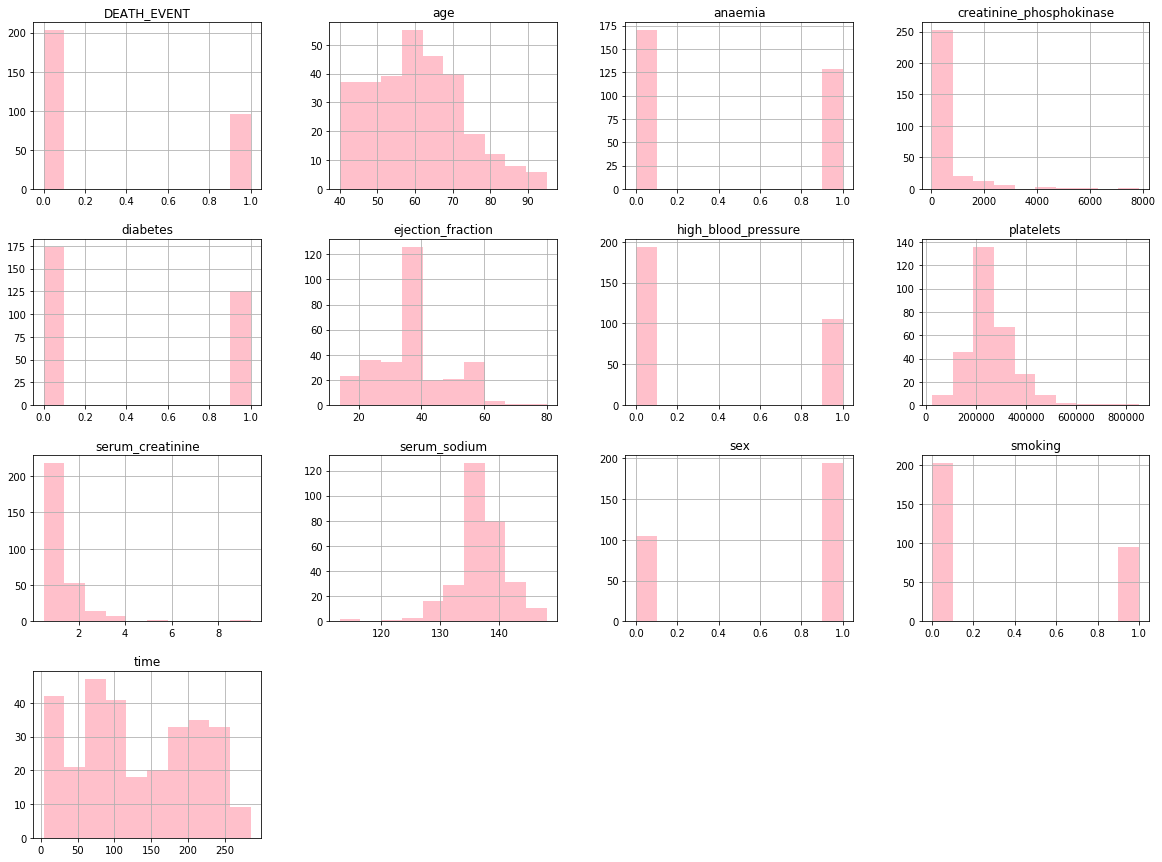

In [1481]:
# Histograms for all numerical attributes 
df.hist(figsize = (20,15), color='pink')

1. The features have widely different scales. Scaling will be needed.

2. Some distributions are tail heavy - Age, creatine_phosphokinase, serum_creatinine.  

#### Create a test set

Since serum creatinine and ejection fraction are the major features of interest, it needs to be ensured an equal distribution of these features in the train and test set. 

In [1482]:
# # Zooming in on serum creatinine

# sns.distplot(df['serum_creatinine'])

Though the distribution has a tail, most of the data is concentrated in a limited region from 2 to 4. We can assume that the train and test set will have equal distribution of this feature. 

In [1483]:
# # Zooming in on ejection fraction

# sns.distplot(df['ejection_fraction'], bins=4, color='m')

The distribution is wide with significant and different distribution across the width. Ensure that it is distributed equally in train and test set.  

In [1484]:
# # Categorizing the ejection_fraction data

# df['EF_cat'] = pd.cut(df['ejection_fraction'], bins=[0, 30, 50, np.inf], labels=['Below 30', '30-50', 'Above 50'])
# sns.catplot(x='EF_cat', kind='count', data=df)

In [1485]:
# shuffle the entire data

df = shuffle(df)

In [1486]:
# Use train_test_split and create a train and test set

df_train_01, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [1487]:
# Use train_test_split and create a train and validation set

df_train, df_validation = train_test_split(df_train_01, test_size=0.2, random_state=42)

In [1488]:
# # Drop the EF_cat column

# for set_ in (df_train, df_test):
#     set_.drop('EF_cat', axis=1, inplace=True)

#### Feature selection

In [1489]:
# Look for correlations
df_train.corr()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.000000,0.148281,-0.051757,-0.078133,0.093099,0.151961,-0.000181,0.232704,-0.114578,0.014263,-0.095674,-0.277257,0.289776
anaemia,0.148281,1.000000,-0.209558,-0.021925,0.010728,-0.021925,-0.080748,0.010103,0.113536,-0.060981,-0.070770,-0.058368,0.049859
creatinine_phosphokinase,-0.051757,-0.209558,1.000000,0.023730,-0.077981,-0.085285,-0.036172,0.012045,0.064412,0.095812,0.041943,-0.009401,0.066549
diabetes,-0.078133,-0.021925,0.023730,1.000000,0.020603,0.013615,0.109435,-0.071029,-0.041961,-0.160875,-0.132906,0.099559,-0.043236
ejection_fraction,0.093099,0.010728,-0.077981,0.020603,1.000000,0.052945,0.049281,-0.057313,0.159729,-0.190230,-0.119938,-0.045787,-0.234792
high_blood_pressure,0.151961,-0.021925,-0.085285,0.013615,0.052945,1.000000,0.001018,0.039790,0.023375,-0.068323,-0.041097,-0.312073,0.194750
platelets,-0.000181,-0.080748,-0.036172,0.109435,0.049281,0.001018,1.000000,0.045235,0.108931,-0.054015,0.059999,-0.050175,-0.037185
serum_creatinine,0.232704,0.010103,0.012045,-0.071029,-0.057313,0.039790,0.045235,1.000000,-0.162340,0.083461,0.019601,-0.227967,0.323576
serum_sodium,-0.114578,0.113536,0.064412,-0.041961,0.159729,0.023375,0.108931,-0.162340,1.000000,-0.169233,-0.089876,0.003718,-0.102134
sex,0.014263,-0.060981,0.095812,-0.160875,-0.190230,-0.068323,-0.054015,0.083461,-0.169233,1.000000,0.444762,-0.028900,0.028935


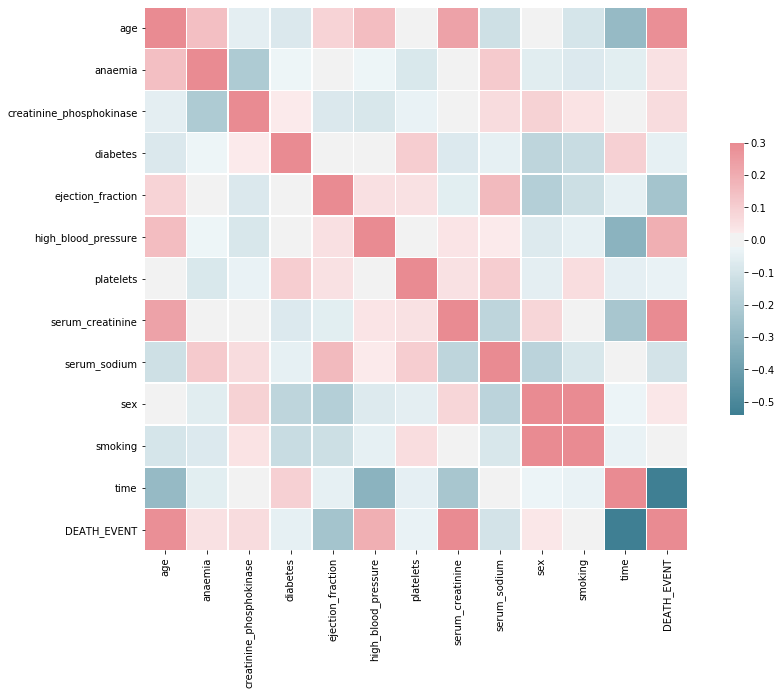

In [1490]:
mask = np.triu(np.ones_like(df_train.corr(), dtype=np.bool))

f, ax = plt.subplots(figsize=(15, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(df_train.corr(), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

time - -0.53 - very high 

age - 0.23 - high 
ejection fraction - -0.24 - high
serum_creatinine - 0.29 - high
serum_sodium - -0.16 - high 

anaemia - 0.07 - mild 
creatine_phosphokinase - 0.09 - mild 
high blood pressure - 0.07 - mild

diabetes - 0.02 - very mild
platelets - -0.02 - very mild

sex - 0.0016 - negligible
smoking - 0.004 - negligible

Top 5 are the most important features here. 

Sex and Smoking (0.48) & creatinine_phosphokinase & anaemia (-0.20) are highly correlated 

Based on the correlation data, time, serum_creatinine, ejection_fraction and age are the most correlated features (in that sequence) with death event. The study already gives us an idea that s_c and e_j are most important. Therefore, this analysis will consider time, s_c, e_j and age as the features for prediction. 

#### EDA and feature engineering

Let us do a thorough data analysis and find out if any new interesting features can be created out of the data. 

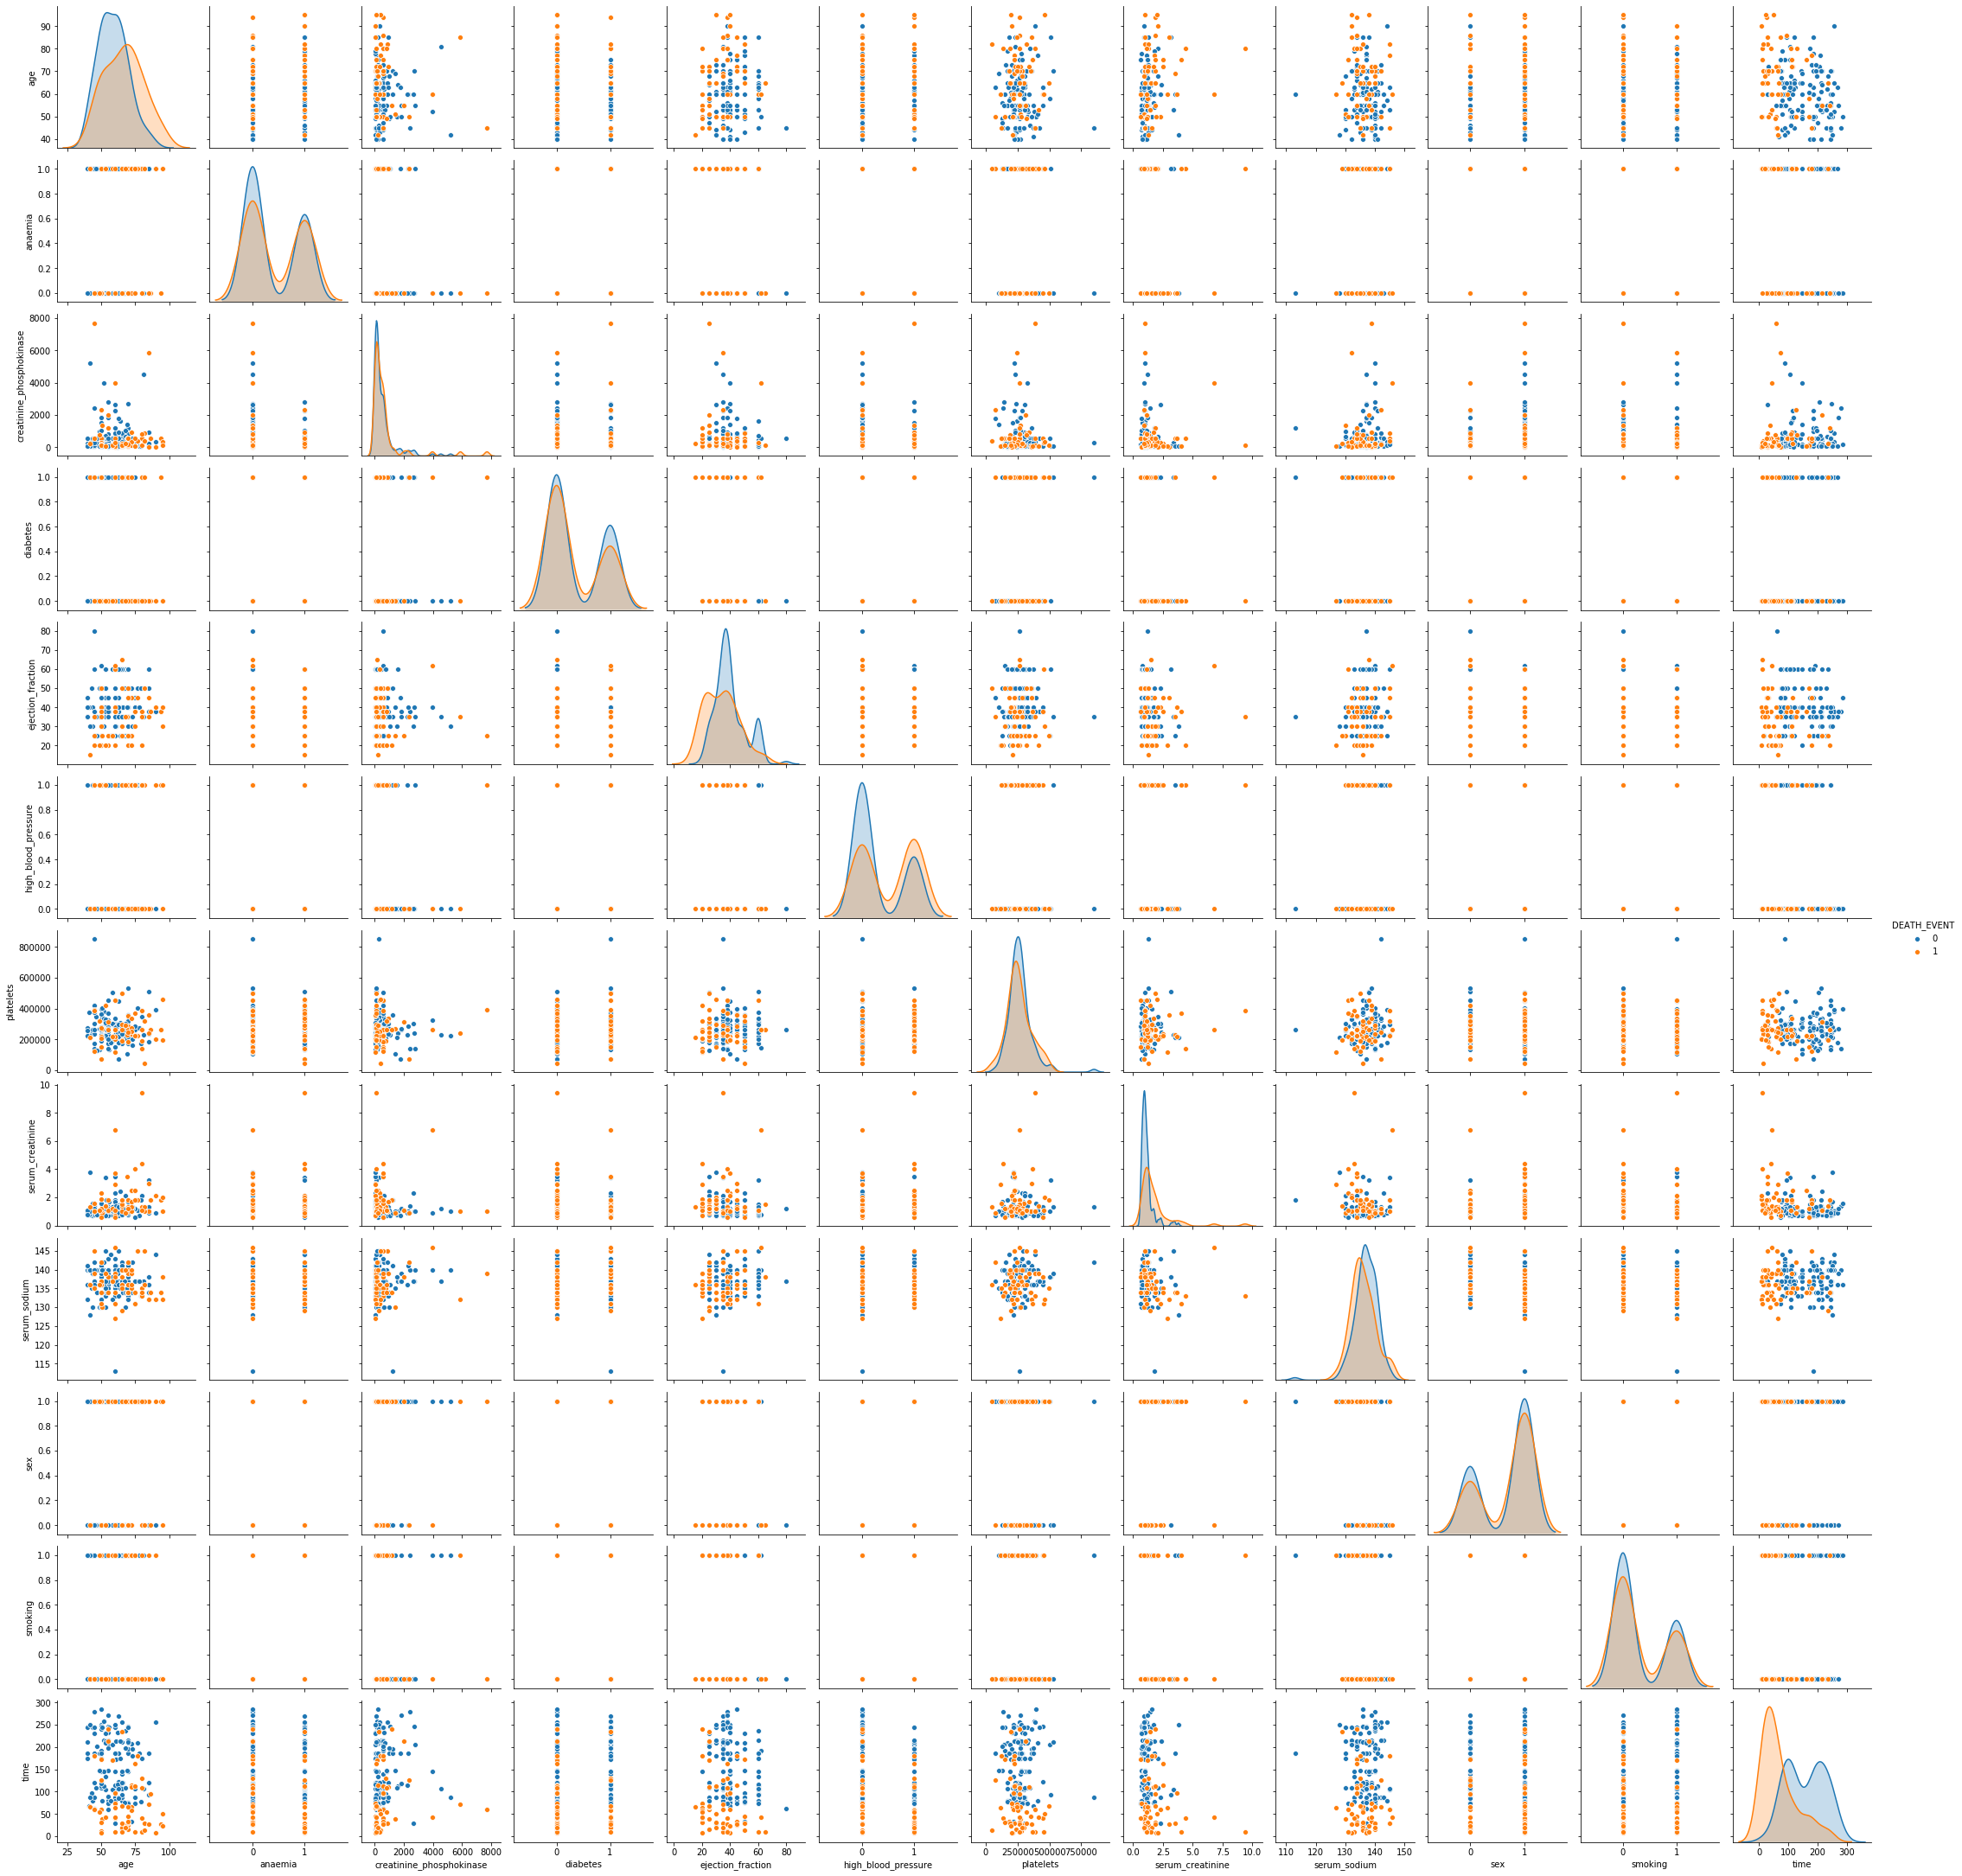

In [1491]:
sns.pairplot(df_train, hue='DEATH_EVENT')

##### Anaemia and heart failure

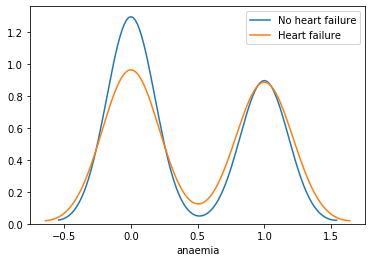

In [1492]:
# Distribution of Anaemia vs Heart failure 
fig, ax = plt.subplots()
sns.distplot(df[df['DEATH_EVENT']==0]['anaemia'], hist=False, label = 'No heart failure')
sns.distplot(df[df['DEATH_EVENT']==1]['anaemia'], hist=False, label = 'Heart failure')

In [1554]:
df_ad = df_train.groupby('anaemia')['DEATH_EVENT'].value_counts().to_frame()
#print(df_ad)
print('Proportion of Non-anaemic people who have Heart failure:', ((df_ad.loc[(0, 1), :]/((df_ad.loc[(0, 0), :]) + (df_ad.loc[(0, 1), :])))*100).values) # proportion of non anaemic people who have heart failure
print('Proportion of Anaemic people who have Heart failure:', ((df_ad.loc[(1, 1), :]/((df_ad.loc[(1, 0), :]) + (df_ad.loc[(1, 1), :])))*100).values) # proportion of anaemic people who have heart failure 

Proportion of Non-anaemic people who have Heart failure: [27.43362832]
Proportion of Anaemic people who have Heart failure: [32.05128205]


From the distplot, we can see that more proportion of anaemic patients suffer from heart failure vis-a-vis non-anaemic patients. To be exact, 30% of non-anaemic people suffer from heart failure while for anaemic patients, the proportion is 36.7%. Though it is not determined whether this difference is statistically significant or not and the difference is not controlled for other risk factors, a general trend can be inferred that anaemic patients are at a higher risk for heart failure than non-anaemic patients. 


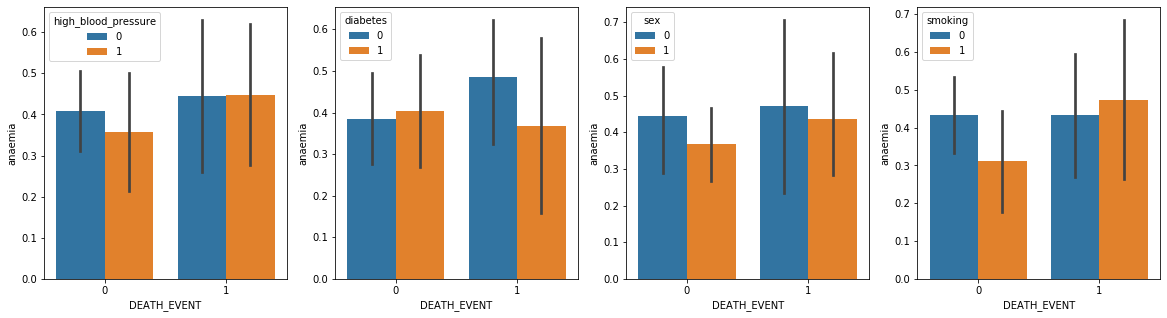

In [1494]:
# Anaemia, heart failure and other risk factors

fig, ax = plt.subplots(1,4, figsize=(20,5))
x=0

for variable in ['high_blood_pressure', 'diabetes', 'sex', 'smoking']:
    sns.barplot(x='DEATH_EVENT', y='anaemia', hue=variable , data=df_train, ax=ax[x])
    x+=1
    #fig = px.bar(df_train, x='DEATH_EVENT', y='anaemia', barmode='group', color=variable)
    #fig.show()

From the barplots, we can see that, in general, anaemic patients have higher chance of heart failure than non-anaemic ones.
1. For males, having anaemia or not does not seem to impact heart failure event. Females who are anaemic undergo heart failure more than non-anaemic ones. Also, females are more anaemic than males, especially in case of those who undergo heart failure. Thus, anaemia is an important risk factor especially for females. 
2. For smokers, having anaemia or not does not seem to impact heart failure event. Non-smokers who are anaemic undergo heart failure more than anaemic ones. A logical jump can be made that anaemic patients are already at a higher risk for heart failure that smoking does not add significantly to it. However, non-anaemic patients who other wise would have been at a lesser risk add to their risk by smoking. 
3. Anaemic patients are at a higher risk for heart failure irrespective of their BP level or diabetes. 

In [1495]:
# Correlation between anaemia and heart failure adjusted for other risk indicators

for variable in ['high_blood_pressure', 'diabetes', 'sex', 'smoking']:
    for x in [0,1]:
        print('For patients with', variable, '=', x, 'correlation of anaemia with heart failure is', 
              ((df_train[df_train[variable]==x]).corr()['anaemia']['DEATH_EVENT']))
        

For patients with high_blood_pressure = 0 correlation of anaemia with heart failure is 0.030358837035945767
For patients with high_blood_pressure = 1 correlation of anaemia with heart failure is 0.09166131662691245
For patients with diabetes = 0 correlation of anaemia with heart failure is 0.09455571074640794
For patients with diabetes = 1 correlation of anaemia with heart failure is -0.03209048852716419
For patients with sex = 0 correlation of anaemia with heart failure is 0.023435855084988053
For patients with sex = 1 correlation of anaemia with heart failure is 0.0652610666168493
For patients with smoking = 0 correlation of anaemia with heart failure is -0.0008261359951610593
For patients with smoking = 1 correlation of anaemia with heart failure is 0.1548017608866552


The plots as well as corr function indicate no significant impact of other indicators on Anaemia-death relation other than a slight spike for female anaemia patients. 

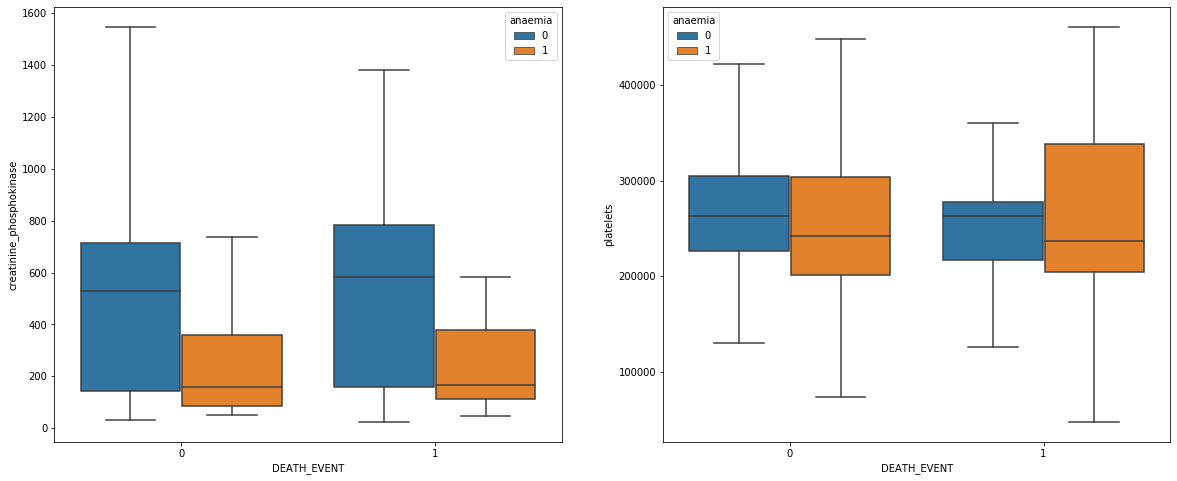

In [1496]:
# Check whether anaemia has an impact on relation between numerical variables and death 

fig, ax = plt.subplots(1,2, figsize=(20,8))
x=0

for variable in ['creatinine_phosphokinase', 'platelets']:
    sns.boxplot(y=variable, x='DEATH_EVENT', hue='anaemia', showfliers=False, data=df_train, ax=ax[x])
    x+=1


Non-anaemic patients who undergo heart failure have a much higher creatinine_phosphokinase level than those who dont undergo heart failure. Such a difference is not seen in case of anaemic patients. It can be inferred that high c_p levels are important indicator of heart failure for non-anaemic patients.

Platelets level do not seem to make any impact on death event vis-a-vis anaemia. 

Lets check the corr value. 

In [1497]:
# corr value for c_p and platelets with death event for anaemic and non-anaemic patients

for variable in ['creatinine_phosphokinase', 'platelets']:
    for x in [0,1]:
        print('For patients with anaemia =', x, 'correlation of death event and', variable, 'is',
              ((df_train[df_train['anaemia']==x]).corr()[variable]['DEATH_EVENT']))


For patients with anaemia = 0 correlation of death event and creatinine_phosphokinase is 0.11774839940688464
For patients with anaemia = 1 correlation of death event and creatinine_phosphokinase is -0.022787197539554944
For patients with anaemia = 0 correlation of death event and platelets is -0.0870762379334909
For patients with anaemia = 1 correlation of death event and platelets is 0.04502844586028053


The corr value between death event and c_p level for non-anaemic patients is 0.1683. This reinforces our previous insight that high c_p levels are important indicator of heart failure for non-anaemic patients.

In [1555]:
# # Does anaemia impact heart failure vis-a-vis top 5 features

# for variable in ['age', 'ejection_fraction','serum_creatinine', 'serum_sodium', 'time']:
#     for x in [0,1]:
#         print('For patients with anaemia =', x, 'correlation of death event and', variable, 'is',
#               ((df_train[df_train['anaemia']==x]).corr()[variable]['DEATH_EVENT']))

Having anaemia or not does not seem to have a significant impact on relation between top 5 features and heart failure. 

Since there is a moderately high correlation between anaemia and death for females, lets see if there is a correlation between all features and death for anaemic females. 

In [1556]:
# correlation between anaemic females and heart failure  

# (df_train[(df_train['anaemia']==1) & (df_train['sex']==0)]).corr()['DEATH_EVENT']

Correlation of 0.27 between diabetes and death and of -0.25 between serum_sodium and death for anaemic females. 

The features diabetes, sex, serum_sodium and anaemia are not correlated to death for whole data. But, anaemic females who have diabetes OR low sodium are highly correlated with heart failure. All in all, anaemia increases the impact of other risk factors as well for females.

In [1500]:
# Correlation between females with anaemia and all data

df_train['FemalesWithAnaemia']=((df_train['anaemia']==1) & (df_train['sex']==0)).fillna(0).astype(int)
print(df_train.corr()['FemalesWithAnaemia']['DEATH_EVENT'])
df_train.drop('FemalesWithAnaemia', axis=1, inplace=True)

-0.006809673283492829


C:\Users\AniketBandhekar\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AniketBandhekar\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No significant correlation between females with anaemia and all data. 

##### High blood pressure and heart failure

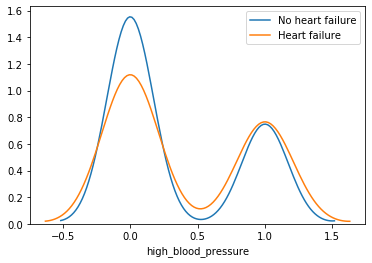

In [1501]:
# Distribution of High blood pressure vs Heart failure 
fig, ax = plt.subplots()
sns.distplot(df[df['DEATH_EVENT']==0]['high_blood_pressure'], hist=False, label = 'No heart failure')
sns.distplot(df[df['DEATH_EVENT']==1]['high_blood_pressure'], hist=False, label = 'Heart failure')

In [1502]:
df_bp = df_train.groupby('high_blood_pressure')['DEATH_EVENT'].value_counts().to_frame()
#print(df_bp)
print('Proportion of people without high BP who have Heart failure:', ((df_bp.loc[(0, 1), :]/((df_bp.loc[(0, 0), :]) + (df_bp.loc[(0, 1), :])))*100).values) 
print('Proportion of people with high BP who have Heart failure:', ((df_bp.loc[(1, 1), :]/((df_bp.loc[(1, 0), :]) + (df_bp.loc[(1, 1), :])))*100).values) 

Proportion of people without high BP who have Heart failure: [22.5]
Proportion of people with high BP who have Heart failure: [40.84507042]


More proportion of people with high BP undergo heart failure than people without high BP.  

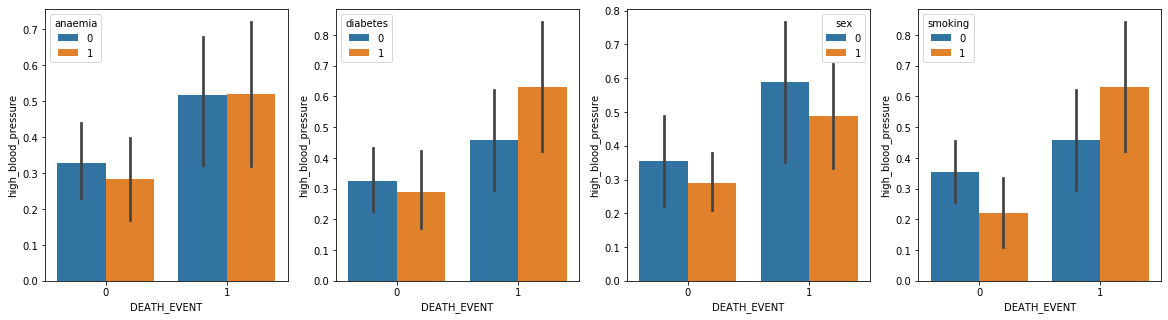

In [1503]:
# High blood pressure and death and impact of other variables 

fig, ax = plt.subplots(1,4, figsize=(20,5))
x=0

for variable in ['anaemia', 'diabetes', 'sex', 'smoking']:
    sns.barplot(x='DEATH_EVENT', y='high_blood_pressure', hue=variable , data=df_train, ax=ax[x])
    x+=1
    #fig = px.bar(df_train, x='DEATH_EVENT', y='anaemia', barmode='group', color=variable)
    #fig.show()

From the bar plots, it can be seen that patients who undergo heart failure have higher BP in general. Specifically,
1. Anaemia doesnt have an impact on heart failure for high BP patients. 
2. Diabetics with high BP are at a higher risk for heart failure than diabetics who dont have high BP.
3. Females with high BP are at a higher risk for heart failure than females who dont have high BP. For males, high BP doesnt seem to have impact.
4. Smokers with high BP are at a higher risk for heart failure than smokers who dont have high BP. 

Thus, high BP is an important risk factor for females, diabetics and smokers. 

In [1504]:
# Correlation between high BP and heart failure adjusted for other risk indicators

for variable in ['anaemia', 'diabetes', 'sex', 'smoking']:
    for x in [0,1]:
        print('For patients with', variable, '=', x, 'correlation of high_blood_pressure with heart failure is', 
              ((df_train[df_train[variable]==x]).corr()['high_blood_pressure']['DEATH_EVENT']))

For patients with anaemia = 0 correlation of high_blood_pressure with heart failure is 0.17172067570480581
For patients with anaemia = 1 correlation of high_blood_pressure with heart failure is 0.2305460528393066
For patients with diabetes = 0 correlation of high_blood_pressure with heart failure is 0.12856542014982109
For patients with diabetes = 1 correlation of high_blood_pressure with heart failure is 0.312905362167099
For patients with sex = 0 correlation of high_blood_pressure with heart failure is 0.21035428362902767
For patients with sex = 1 correlation of high_blood_pressure with heart failure is 0.1910776016281949
For patients with smoking = 0 correlation of high_blood_pressure with heart failure is 0.0969859090235468
For patients with smoking = 1 correlation of high_blood_pressure with heart failure is 0.39377578085210035


The graphs as well as corr values indicate a moderate correlation between high BP and heart failure for diabetics, females or smokers. This reinforces our previous insights. Lets explore the corr further. 

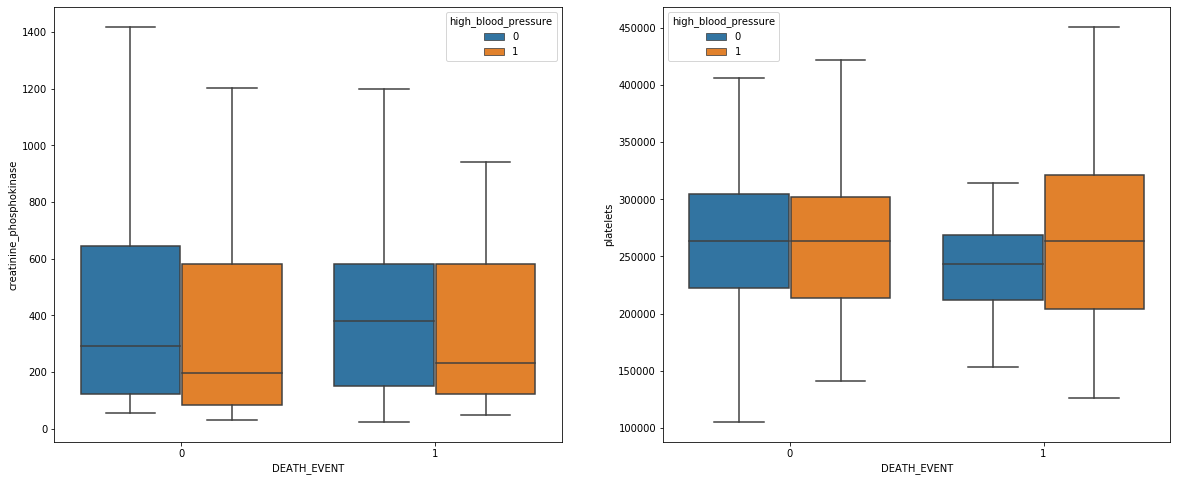

In [1505]:
# Check whether high BP has an impact on relation between numerical variables and death 

fig, ax = plt.subplots(1,2, figsize=(20,8))
x=0

for variable in ['creatinine_phosphokinase', 'platelets']:
    sns.boxplot(y=variable, x='DEATH_EVENT', hue='high_blood_pressure', showfliers=False, data=df_train, ax=ax[x])
    x+=1

It can be inferred that high c_p levels are an important indicator of heart failure for high BP patients. Platelet levels are not significant. 

In [1506]:
for variable in ['creatinine_phosphokinase', 'platelets']:
    for x in [0,1]:
        print('For patients with high BP =', x, 'correlation of death event and', variable, 'is',
              ((df_train[df_train['high_blood_pressure']==x]).corr()[variable]['DEATH_EVENT']))

For patients with high BP = 0 correlation of death event and creatinine_phosphokinase is 0.07510454977048789
For patients with high BP = 1 correlation of death event and creatinine_phosphokinase is 0.10101481834421279
For patients with high BP = 0 correlation of death event and platelets is -0.07137191847643783
For patients with high BP = 1 correlation of death event and platelets is 0.020335117328589336


No significant correlation here except a slight uptick for high BP patients for c_p.

In [1507]:
# See the role of other risk factors for females with high BP

df_train[(df_train['high_blood_pressure']==1) & (df_train['sex']==0)].corr()['DEATH_EVENT']

age                         0.326185
anaemia                     0.283110
creatinine_phosphokinase   -0.117583
diabetes                    0.123091
ejection_fraction          -0.231016
high_blood_pressure              NaN
platelets                  -0.235405
serum_creatinine            0.415584
serum_sodium               -0.123407
sex                              NaN
smoking                     0.068465
time                       -0.641921
DEATH_EVENT                 1.000000
Name: DEATH_EVENT, dtype: float64

Females with high BP are more vulnerable to heart failure if they have diabetes or low platelets count.

In [1508]:
# Assess the correlation between patients who are females with high BP and all data so that a new feature can be made

df_train['FemalesWithHighBP']=((df_train['high_blood_pressure']==1) & (df_train['sex']==0)).fillna(0).astype(int)
print(df_train.corr()['FemalesWithHighBP']['DEATH_EVENT'])
df_train.drop('FemalesWithHighBP', axis=1, inplace=True)


0.07971981992317245


C:\Users\AniketBandhekar\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AniketBandhekar\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No significant correlation between females with High BP and all data. 

In [1509]:
# See the role of other risk factors for diabetics with high BP

df_train[(df_train['diabetes']==1) & (df_train['high_blood_pressure']==0)].corr()['DEATH_EVENT'] 

age                         0.039817
anaemia                     0.102101
creatinine_phosphokinase    0.210195
diabetes                         NaN
ejection_fraction          -0.034439
high_blood_pressure              NaN
platelets                  -0.014552
serum_creatinine            0.432457
serum_sodium               -0.018191
sex                         0.002851
smoking                    -0.066519
time                       -0.503743
DEATH_EVENT                 1.000000
Name: DEATH_EVENT, dtype: float64

No significant impact of other risk factors for diabetics with high BP

In [1510]:
# Assess the correlation between patients who are diabetics with high BP and all data so that a new feature can be made

df_train['DiabeticsWithHighBP']=((df_train['diabetes']==1) & (df_train['high_blood_pressure']==1)).fillna(0).astype(int)
print(df_train.corr()['DiabeticsWithHighBP']['DEATH_EVENT'])
df_train.drop('DiabeticsWithHighBP', axis=1, inplace=True)

0.13481241817090542


C:\Users\AniketBandhekar\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No significant correlation between diabetics with High BP and all data. 

In [1511]:
df_train[(df_train['high_blood_pressure']==1) & (df_train['smoking']==1)].corr()['DEATH_EVENT']

age                         0.399457
anaemia                     0.120761
creatinine_phosphokinase    0.132243
diabetes                    0.016879
ejection_fraction          -0.399263
high_blood_pressure              NaN
platelets                   0.207260
serum_creatinine            0.254235
serum_sodium               -0.184449
sex                         0.028868
smoking                          NaN
time                       -0.769345
DEATH_EVENT                 1.000000
Name: DEATH_EVENT, dtype: float64

No significant impact of other risk factors for smokers with high BP. platelets counts corr doesnt make sense here. 

In [1512]:
# Assess the correlation between patients who are diabetics with high BP and all data so that a new feature can be made

df_train['SmokersWithHighBP']=((df_train['diabetes']==1) & (df_train['smoking']==1)).fillna(0).astype(int)
print(df_train.corr()['SmokersWithHighBP']['DEATH_EVENT'])
df_train.drop('SmokersWithHighBP', axis=1, inplace=True)

0.028441918297772508


C:\Users\AniketBandhekar\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No significant correlation between smokers with High BP and all data.

We can make further combinations too here such as female smokers with high BP but that will too much of a specific group which the study may not be interested in. 

##### Diabetes and heart failure 

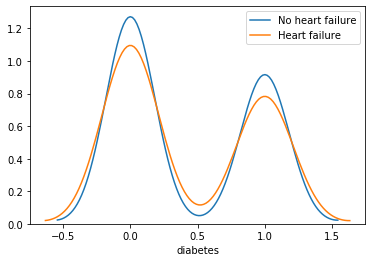

In [1513]:
# Distribution of diabetes vs Heart failure 

fig, ax = plt.subplots()
sns.distplot(df[df['DEATH_EVENT']==0]['diabetes'], hist=False, label = 'No heart failure')
sns.distplot(df[df['DEATH_EVENT']==1]['diabetes'], hist=False, label = 'Heart failure')

In [1514]:
df_d = df_train.groupby('diabetes')['DEATH_EVENT'].value_counts().to_frame()
#print(df_d)
print('Proportion of people without diabetes who have Heart failure:', ((df_d.loc[(0, 1), :]/((df_d.loc[(0, 0), :]) + (df_d.loc[(0, 1), :])))*100).values) 
print('Proportion of people with diabetes who have Heart failure:', ((df_d.loc[(1, 1), :]/((df_d.loc[(1, 0), :]) + (df_d.loc[(1, 1), :])))*100).values) 

Proportion of people without diabetes who have Heart failure: [30.83333333]
Proportion of people with diabetes who have Heart failure: [26.76056338]


More proportion of people who have diabetes undergo heart failure than those who dont have diabetes. The difference is not too large though. 

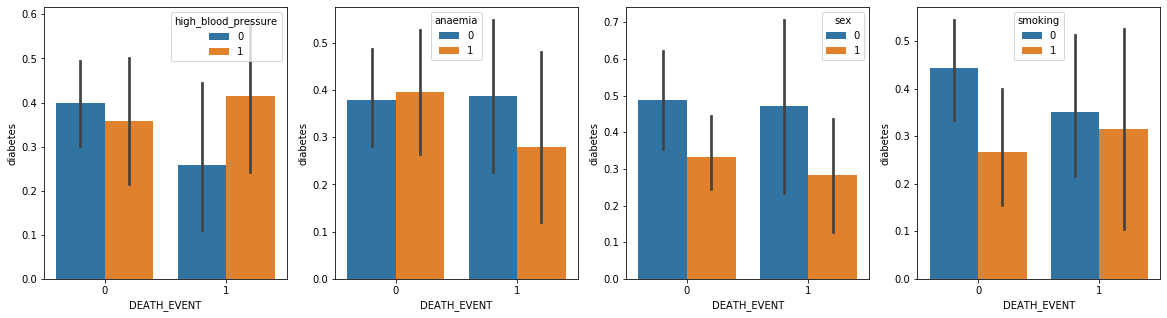

In [1515]:
# Diabetes and heart failure

# Diabetes and death have very low correlation. However, we can check whether any of the categorical variables have an impact on relation between Diabetes and death

fig, ax = plt.subplots(1,4, figsize=(20,5))
x=0

for variable in ['high_blood_pressure', 'anaemia', 'sex', 'smoking']:
    sns.barplot(x='DEATH_EVENT', y='diabetes', hue=variable , data=df_train, ax=ax[x])
    x+=1
    #fig = px.bar(df_train, x='DEATH_EVENT', y='anaemia', barmode='group', color=variable)
    #fig.show()

1. For people with high BP, having diabetes increases the risk of heart failure.
2. For anaemic people, having diabetes or not does not seem to make much impact.
3. For females, having diabetes increases the risk of heart failure a lot. Moroever, diabetes increases the risk for females more than it does for males. For males, having diabetes does not seem to have much impact on heart failure.
4. Smokers who have diabetes have higher risk of heart failure. For non-smokers, diabetes doesnt have much impact. 

In [1516]:
# Correlation between diabetes and heart failure adjusted for other risk indicators

for variable in ['high_blood_pressure', 'anaemia', 'sex', 'smoking']:
    for x in [0,1]:
        print('For patients with', variable, '=', x, 'correlation of diabetes with heart failure is', 
              ((df_train[df_train[variable]==x]).corr()['diabetes']['DEATH_EVENT']))

For patients with high_blood_pressure = 0 correlation of diabetes with heart failure is -0.12009439902565665
For patients with high_blood_pressure = 1 correlation of diabetes with heart failure is 0.057361067662618774
For patients with anaemia = 0 correlation of diabetes with heart failure is 0.008314895876232577
For patients with anaemia = 1 correlation of diabetes with heart failure is -0.11307035712501011
For patients with sex = 0 correlation of diabetes with heart failure is -0.016336600980326795
For patients with sex = 1 correlation of diabetes with heart failure is -0.050580798654860426
For patients with smoking = 0 correlation of diabetes with heart failure is -0.08577994874708328
For patients with smoking = 1 correlation of diabetes with heart failure is 0.04991729748139844


The graphs as well as corr values indicate a moderate correlation between diabetes and heart failure for high BP patients, females or smokers. 

Not checking the further correlations such as df_train((df_train['high_blood_pressure']==1) & (df_train['diabetes']==0 as it will lead to complicated insights. 

In [1517]:
# Check if a new feature can be created

#df_train['DiabeticsWithHighBP']=((df_train['high_blood_pressure']==1) & (df_train['diabetes']==0)).fillna(0).astype(int)

df_train['DiabeticsWithHighBP']=((df_train['high_blood_pressure']==1) & (df_train['diabetes']==1)).fillna(0).astype(int)
print(df_train.corr()['DiabeticsWithHighBP']['DEATH_EVENT'])
df_train.drop('DiabeticsWithHighBP', axis=1, inplace=True)

0.13481241817090542


C:\Users\AniketBandhekar\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AniketBandhekar\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No significant correlation between diabetics with High BP and all data

In [1518]:
#df_train['FemalesWithDiabetes']=((df_train['diabetes']==0) & (df_train['sex']==0)).fillna(0).astype(int)

df_train['FemalesWithDiabetes']=((df_train['diabetes']==1) & (df_train['sex']==0)).fillna(0).astype(int)
print(df_train.corr()['FemalesWithDiabetes']['DEATH_EVENT'])
df_train.drop('FemalesWithDiabetes', axis=1, inplace=True)
# No significant correlation between female diabetics and all data.

-0.02515411979101206


C:\Users\AniketBandhekar\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No significant correlation between female diabetics and all data

In [1519]:
df_train['SmokersWithDiabetes']=((df_train['diabetes']==1) & (df_train['smoking']==1)).fillna(0).astype(int)

#df_train['SmokersWithDiabetes']=((df_train['diabetes']==1) & (df_train['smoking']==0)).fillna(0).astype(int)
print(df_train.corr()['SmokersWithDiabetes']['DEATH_EVENT'])
df_train.drop('SmokersWithDiabetes', axis=1, inplace=True)
# No significant correlation between smokers diabetics and all data.

0.028441918297772508


C:\Users\AniketBandhekar\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No significant correlation between smoker diabetics and all data

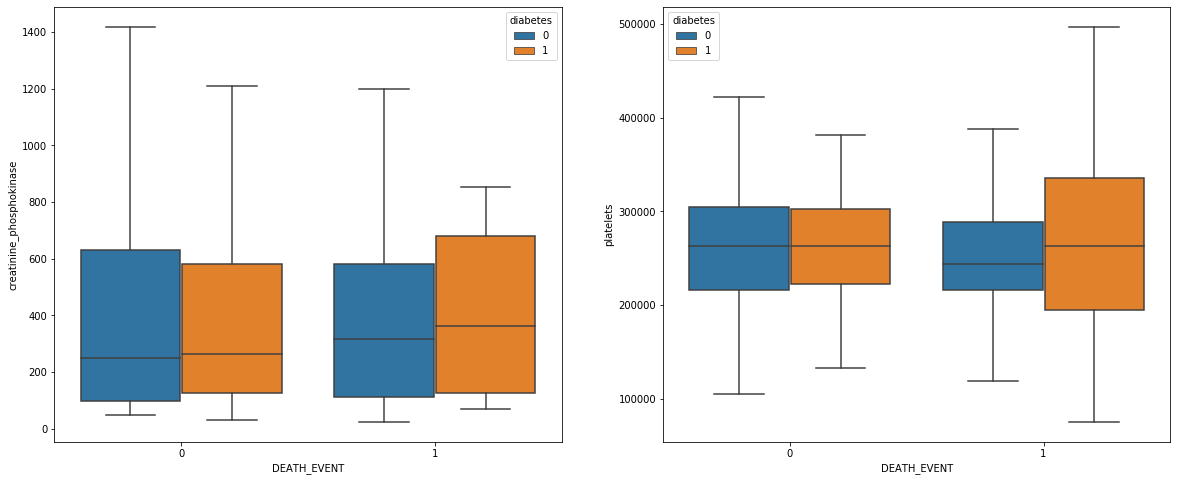

In [1520]:
# Check whether diabetes has an impact on relation between numerical variables and death 

fig, ax = plt.subplots(1,2, figsize=(20,8))
x=0

for variable in ['creatinine_phosphokinase', 'platelets']:
    sns.boxplot(y=variable, x='DEATH_EVENT', hue='diabetes', showfliers=False, data=df_train, ax=ax[x])
    x+=1

In [1521]:
for variable in ['creatinine_phosphokinase', 'platelets']:
    for x in [0,1]:
        print('For patients with diabetes =', x, 'correlation of death event and', variable, 'is',
              ((df_train[df_train['diabetes']==x]).corr()[variable]['DEATH_EVENT']))

For patients with diabetes = 0 correlation of death event and creatinine_phosphokinase is -0.023995112405920675
For patients with diabetes = 1 correlation of death event and creatinine_phosphokinase is 0.2091884249870924
For patients with diabetes = 0 correlation of death event and platelets is -0.03900032042472366
For patients with diabetes = 1 correlation of death event and platelets is -0.025874262695542802


No correlation stands out. c_p or platelets count does not seem to vary significantly across diabetic or non-diabetic patients. c_p or platelet counts are not an indicator of heart failure for diabetic patients.

##### Sex and heart failure

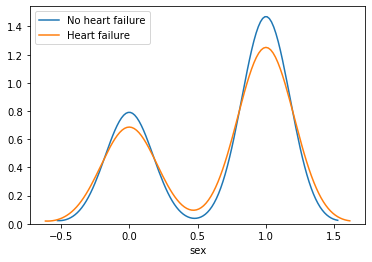

In [1522]:
# Distribution of High blood pressure vs Heart failure 
fig, ax = plt.subplots()
sns.distplot(df[df['DEATH_EVENT']==0]['sex'], hist=False, label = 'No heart failure')
sns.distplot(df[df['DEATH_EVENT']==1]['sex'], hist=False, label = 'Heart failure')

In [1523]:
df_mf = df_train.groupby('sex')['DEATH_EVENT'].value_counts().to_frame()
#print(df_d)
print('Proportion of females who have Heart failure:', ((df_mf.loc[(0, 1), :]/((df_mf.loc[(0, 0), :]) + (df_mf.loc[(0, 1), :])))*100).values) 
print('Proportion of males who have Heart failure:', ((df_mf.loc[(1, 1), :]/((df_mf.loc[(1, 0), :]) + (df_mf.loc[(1, 1), :])))*100).values) 

Proportion of females who have Heart failure: [27.41935484]
Proportion of males who have Heart failure: [30.23255814]


No significant difference between males and females with regards to heart failure.

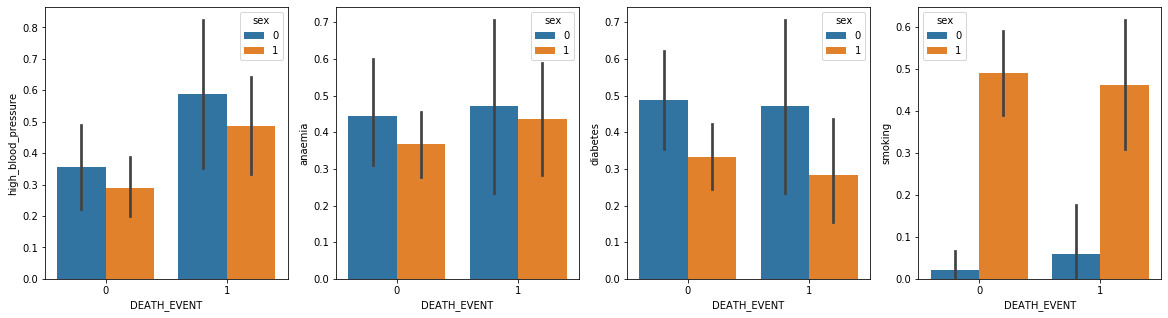

In [1524]:
# Impact of other variables on Sex and heart failure

fig, ax = plt.subplots(1,4, figsize=(20,5))
x=0

for variable in ['high_blood_pressure', 'anaemia', 'diabetes', 'smoking']:
    sns.barplot(x='DEATH_EVENT', y=variable, hue='sex' , data=df_train, ax=ax[x])
    x+=1
    #fig = px.bar(df_train, x='DEATH_EVENT', y='anaemia', barmode='group', color=variable)
    #fig.show()

In [1525]:
for variable in ['high_blood_pressure', 'anaemia', 'diabetes', 'smoking']:
    for x in [0,1]:
        print('For patients with', variable, '=', x, 'correlation of sex with heart failure is', 
              ((df_train[df_train[variable]==x]).corr()['sex']['DEATH_EVENT']))

For patients with high_blood_pressure = 0 correlation of sex with heart failure is 0.04790266565758789
For patients with high_blood_pressure = 1 correlation of sex with heart failure is 0.03685836797219572
For patients with anaemia = 0 correlation of sex with heart failure is 0.01415992479565378
For patients with anaemia = 1 correlation of sex with heart failure is 0.05580095546429079
For patients with diabetes = 0 correlation of sex with heart failure is 0.035365280402281256
For patients with diabetes = 1 correlation of sex with heart failure is 0.001814257669411229
For patients with smoking = 0 correlation of sex with heart failure is 0.05138338440090325
For patients with smoking = 1 correlation of sex with heart failure is -0.07985083244631432


Females with high BP, diabetes or anaemia are at a higher risk for heart failure. Smoking also increases the risk for females. All the risk factors dont seem to make a significant impact in case of males, however. 

In [1526]:
# check for new feature

#df_train['SmokersMales']=((df_train['sex']==1) & (df_train['smoking']==1)).fillna(0).astype(int)

df_train['SmokersFemales']=((df_train['sex']==0) & (df_train['smoking']==1)).fillna(0).astype(int)
print(df_train.corr()['SmokersFemales']['DEATH_EVENT'])
df_train.drop('SmokersFemales', axis=1, inplace=True)


0.04673263762499569


C:\Users\AniketBandhekar\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AniketBandhekar\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No significant correlation found for either gender with smoking.

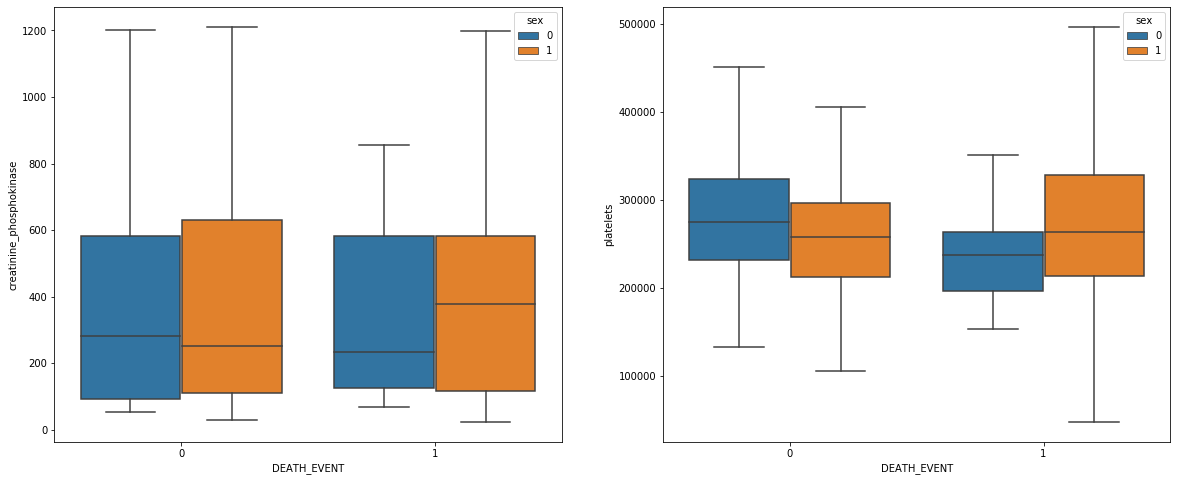

In [1527]:
# Check whether sex has an impact on relation between numerical variables and death 

fig, ax = plt.subplots(1,2, figsize=(20,8))
x=0

for variable in ['creatinine_phosphokinase', 'platelets']:
    sns.boxplot(y=variable, x='DEATH_EVENT', hue='sex', showfliers=False, data=df_train, ax=ax[x])
    x+=1

In [1528]:
for variable in ['creatinine_phosphokinase', 'platelets']:
    for x in [0,1]:
        print('For patients with sex =', x, 'correlation of death event and', variable, 'is',
              ((df_train[df_train['sex']==x]).corr()[variable]['DEATH_EVENT']))

For patients with sex = 0 correlation of death event and creatinine_phosphokinase is 0.1424471094114646
For patients with sex = 1 correlation of death event and creatinine_phosphokinase is 0.04506832796866922
For patients with sex = 0 correlation of death event and platelets is -0.258954696205556
For patients with sex = 1 correlation of death event and platelets is 0.05229448625530883


Males with high c_p seem to be at a higher risk. Females with low platelets seems to be at a higher risk. 

##### Smoking and heart failure

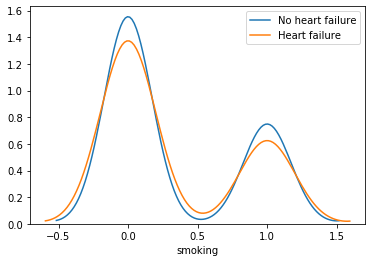

In [1529]:
# Distribution of Anaemia vs Heart failure 
fig, ax = plt.subplots()
sns.distplot(df[df['DEATH_EVENT']==0]['smoking'], hist=False, label = 'No heart failure')
sns.distplot(df[df['DEATH_EVENT']==1]['smoking'], hist=False, label = 'Heart failure')

In [1530]:
df_sm = df_train.groupby('smoking')['DEATH_EVENT'].value_counts().to_frame()
#print(df_sm)
print('Proportion of people who dont smoke and who have Heart failure:', ((df_sm.loc[(0, 1), :]/((df_sm.loc[(0, 0), :]) + (df_sm.loc[(0, 1), :])))*100).values) 
print('Proportion of people who smoke and who have Heart failure:', ((df_sm.loc[(1, 1), :]/((df_sm.loc[(1, 0), :]) + (df_sm.loc[(1, 1), :])))*100).values) 

Proportion of people who dont smoke and who have Heart failure: [29.13385827]
Proportion of people who smoke and who have Heart failure: [29.6875]


No significant difference between smokers and non smokers for heart failure.

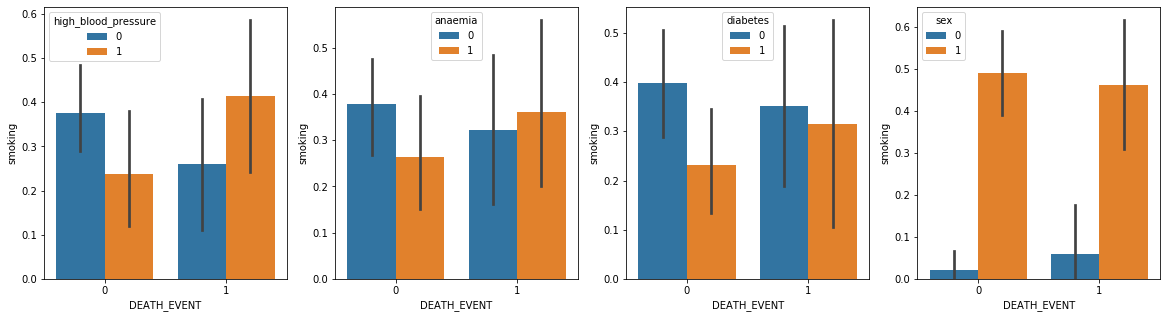

In [1531]:
# Smoking and heart failure

fig, ax = plt.subplots(1,4, figsize=(20,5))
x=0

for variable in ['high_blood_pressure', 'anaemia', 'diabetes', 'sex']:
    sns.barplot(x='DEATH_EVENT', y='smoking', hue=variable, data=df_train, ax=ax[x])
    x+=1
    #fig = px.bar(df_train, x='DEATH_EVENT', y='anaemia', barmode='group', color=variable)
    #fig.show()

In [1532]:
for variable in ['high_blood_pressure', 'anaemia', 'diabetes', 'sex']:
    for x in [0,1]:
        print('For patients with', variable, '=', x, 'correlation of smoking with heart failure is', 
              ((df_train[df_train[variable]==x]).corr()['smoking']['DEATH_EVENT']))

For patients with high_blood_pressure = 0 correlation of smoking with heart failure is -0.10250664689741006
For patients with high_blood_pressure = 1 correlation of smoking with heart failure is 0.1867586598209987
For patients with anaemia = 0 correlation of smoking with heart failure is -0.051472251190600136
For patients with anaemia = 1 correlation of smoking with heart failure is 0.09809582388148622
For patients with diabetes = 0 correlation of smoking with heart failure is -0.04391912311587212
For patients with diabetes = 1 correlation of smoking with heart failure is 0.0865220152596402
For patients with sex = 0 correlation of smoking with heart failure is 0.09241377067782296
For patients with sex = 1 correlation of smoking with heart failure is -0.025141108870409


Smoking increases risk of heart failure for diabetics and high BP patients. 

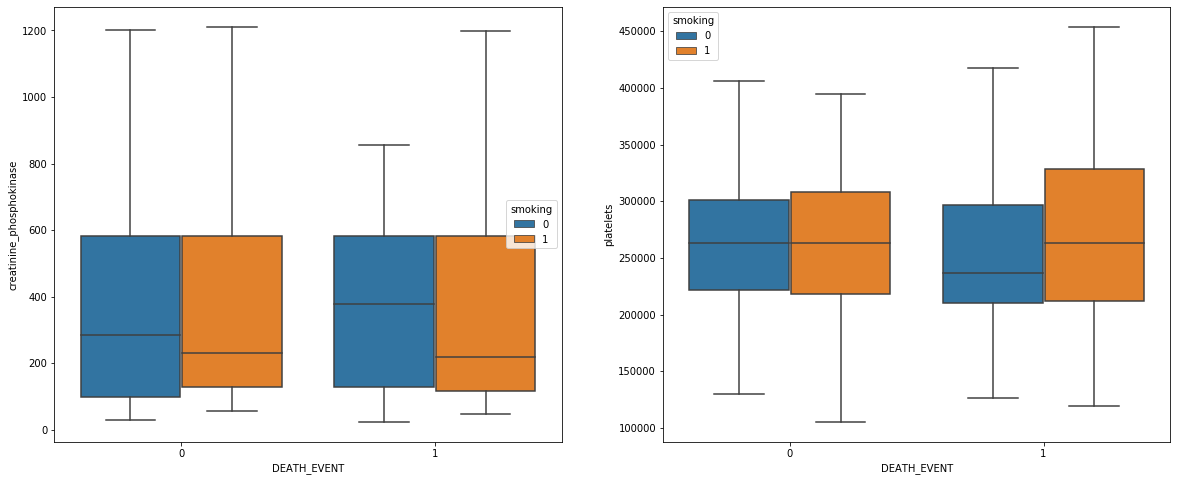

In [1533]:
# Check whether smoking has an impact on relation between numerical variables and death 

fig, ax = plt.subplots(1,2, figsize=(20,8))
x=0

for variable in ['creatinine_phosphokinase', 'platelets']:
    sns.boxplot(y=variable, x='DEATH_EVENT', hue='smoking', showfliers=False, data=df_train, ax=ax[x])
    x+=1

In [1534]:
for variable in ['creatinine_phosphokinase', 'platelets']:
    for x in [0,1]:
        print('For patients with smoking =', x, 'correlation of death event and', variable, 'is',
              ((df_train[df_train['smoking']==x]).corr()[variable]['DEATH_EVENT']))

For patients with smoking = 0 correlation of death event and creatinine_phosphokinase is 0.12479363687277362
For patients with smoking = 1 correlation of death event and creatinine_phosphokinase is -0.021648540558141353
For patients with smoking = 0 correlation of death event and platelets is -0.06696547854903932
For patients with smoking = 1 correlation of death event and platelets is 0.00876189359220001


No significant impact of c_p and platelet count on smoking-heart failure relationship.

#### Deal with missing data

No data missing.

#### Data transformation

No encoding needed as there are no categorical variables.

Standardscaling to be done.

In [1537]:
df_validation['DEATH_EVENT'].value_counts()

0    30
1    18
Name: DEATH_EVENT, dtype: int64

In [1538]:
# Shuffling
df_train = shuffle(df_train)
df_validation = shuffle(df_validation)

In [1539]:
# Standard scaling of training data
X_train = df_train.copy()[['time', 'ejection_fraction', 'serum_creatinine', 'age', 'serum_sodium']]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

y_train = df_train['DEATH_EVENT']

In [1540]:
# Standard scaling of validation data
X_validation = df_validation.copy()[['time', 'ejection_fraction', 'serum_creatinine', 'age', 'serum_sodium']]

scaler = StandardScaler()
X_validation = scaler.fit_transform(X_validation)

y_validation = df_validation['DEATH_EVENT']

##### SGD classifier

In [1541]:
# SGDclassifier and performance analysis

sgd_clf = SGDClassifier()

# Fit the model on training data

sgd_clf.fit(X_train, y_train)

# Predict the values for validation data

y_validation_pred = sgd_clf.predict(X_validation)

# confusion matrix for validation data predictions
print('Confusion matrix for validation data:' '\n', confusion_matrix(y_validation, y_validation_pred))

# accuracy score for validation data predictions 
acc_score = accuracy_score(y_validation, y_validation_pred)
print('Accuracy score for validation data:', acc_score)
      
# precision score for validation data predictions 
pre_score = precision_score(y_validation, y_validation_pred)
print('Precision score for validation data:', pre_score)
      
# recall score for validation data predictions 
rec_score = recall_score(y_validation, y_validation_pred)
print('Recall score for validation data:', rec_score)

accu_scores = []
rec_scores = []
accu_scores.append(acc_score)
rec_scores.append(rec_score)

Confusion matrix for validation data:
 [[25  5]
 [ 6 12]]
Accuracy score for validation data: 0.7708333333333334
Precision score for validation data: 0.7058823529411765
Recall score for validation data: 0.6666666666666666


In [1006]:
# # SGDclassifier and performance analysis

# sgd_clf = SGDClassifier()

# # cross validation
# #scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

# # cross val score is not used to arrive at a final model but to evaluate the models mean performance using small amount
# # of data so that different estimators can be compared better.
# #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# # predicting the values for training data
# y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

# # confusion matrix for training data predictions
# print('Confusion matrix for training data:' '\n', confusion_matrix(y_train, y_train_pred))

# # accuracy score for training data predictions 
# acc_score = accuracy_score(y_train, y_train_pred)
# print('Accuracy score for training data:', acc_score)
      
# # precision score for training data predictions 
# pre_score = precision_score(y_train, y_train_pred)
# print('Precision score for training data:', pre_score)
      
# # recall score for training data predictions 
# rec_score = recall_score(y_train, y_train_pred)
# print('Recall score for training data:', rec_score)

# accu_scores = []
# rec_scores = []
# accu_scores.append(acc_score)
# rec_scores.append(rec_score)

##### Logistic regression

In [1542]:
# Logistic regression and performance analysis

logreg = LogisticRegression()

# Fit the model on training data

logreg.fit(X_train, y_train)

# Predict the values for validation data

y_validation_pred = logreg.predict(X_validation)

# confusion matrix for validation data predictions
print('Confusion matrix for validation data:' '\n', confusion_matrix(y_validation, y_validation_pred))

# accuracy score for validation data predictions 
acc_score = accuracy_score(y_validation, y_validation_pred)
print('Accuracy score for validation data:', acc_score)
      
# precision score for validation data predictions 
pre_score = precision_score(y_validation, y_validation_pred)
print('Precision score for validation data:', pre_score)
      
# recall score for validation data predictions 
rec_score = recall_score(y_validation, y_validation_pred)
print('Recall score for validation data:', rec_score)

accu_scores.append(acc_score)
rec_scores.append(rec_score)

Confusion matrix for validation data:
 [[27  3]
 [ 7 11]]
Accuracy score for validation data: 0.7916666666666666
Precision score for validation data: 0.7857142857142857
Recall score for validation data: 0.6111111111111112


In [1008]:
# # Logistic regression and performance analysis

# logreg = LogisticRegression()

# # cross validation
# # scores = cross_val_score(logreg, X_train, y_train, cv=3, scoring='accuracy')

# # # cross val score is not used to arrive at a final model but to evaluate the models mean performance using small amount
# # # of data so that different estimators can be compared better.
# # print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# # predicting the values for training data
# y_train_pred = cross_val_predict(logreg, X_train, y_train, cv=3)

# # confusion matrix for training data predictions
# print('Confusion matrix for training data:' '\n', confusion_matrix(y_train, y_train_pred))

# # accuracy score for training data predictions 
# acc_score = accuracy_score(y_train, y_train_pred)
# print('Accuracy score for training data:', acc_score)
      
# # precision score for training data predictions 
# pre_score = precision_score(y_train, y_train_pred)
# print('Precision score for training data:', pre_score)
      
# # recall score for training data predictions 
# rec_score = recall_score(y_train, y_train_pred)
# print('Recall score for training data:', rec_score)

# accu_scores.append(acc_score)
# rec_scores.append(rec_score)

##### SVC

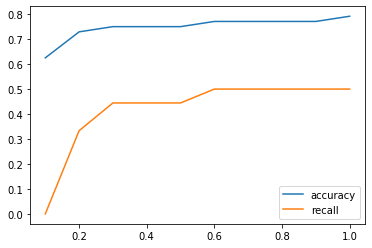

In [1543]:
# Selecting the right hyperparameter

accuracyscores = []
recallscores = []

for c in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    svc = SVC(C=c, random_state=0, kernel='rbf')
    svc.fit(X_train, y_train)
    y_validation_pred = svc.predict(X_validation)
    accuracyscores.append(accuracy_score(y_validation, y_validation_pred))
    recallscores.append(recall_score(y_validation, y_validation_pred))

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], accuracyscores, label='accuracy')
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], recallscores, label='recall')
plt.legend()


In [1544]:
# SVC and performance analysis

svc = SVC(C=1.0, random_state=0, kernel='rbf')

# # cross validation
# scores = cross_val_score(svc, X_train, y_train, cv=3, scoring='accuracy')

# # cross val score is not used to arrive at a final model but to evaluate the models mean performance using small amount
# # of data so that different estimators can be compared better.
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# fit the model on training data
svc.fit(X_train, y_train)

# Predict the values for validation data
y_validation_pred = svc.predict(X_validation)

# confusion matrix for validation data predictions
print('Confusion matrix for validation data:' '\n', confusion_matrix(y_validation, y_validation_pred))

# accuracy score for validation data predictions 
acc_score = accuracy_score(y_validation, y_validation_pred)
print('Accuracy score for validation data:', acc_score)
      
# precision score for validation data predictions 
pre_score = precision_score(y_validation, y_validation_pred)
print('Precision score for validation data:', pre_score)
      
# recall score for validation data predictions 
rec_score = recall_score(y_validation, y_validation_pred)
print('Recall score for validation data:', rec_score)

accu_scores.append(acc_score)
rec_scores.append(rec_score)

Confusion matrix for validation data:
 [[29  1]
 [ 9  9]]
Accuracy score for validation data: 0.7916666666666666
Precision score for validation data: 0.9
Recall score for validation data: 0.5


##### Linear SVC

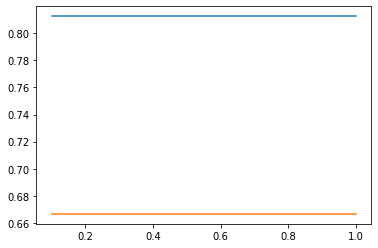

In [1545]:
# Selecting the right hyperparameter

accuracyscores = []
recallscores = []

for c in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    lsvc = LinearSVC(C=c, random_state=0)
    lsvc.fit(X_train, y_train)
    y_validation_pred = lsvc.predict(X_validation)
    accuracyscores.append(accuracy_score(y_validation, y_validation_pred))
    recallscores.append(recall_score(y_validation, y_validation_pred))

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], accuracyscores)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], recallscores)

C values doesnt seem to make an impact.

In [1546]:
# Linear SVC and performance analysis

lsvc = LinearSVC()

# # cross validation
# scores = cross_val_score(lsvc, X_train, y_train, cv=3, scoring='accuracy')

# # cross val score is not used to arrive at a final model but to evaluate the models mean performance using small amount
# # of data so that different estimators can be compared better.
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# fit the model on training data
lsvc.fit(X_train, y_train)

# Predict the values for validation data
y_validation_pred = lsvc.predict(X_validation)

# confusion matrix for validation data predictions
print('Confusion matrix for validation data:' '\n', confusion_matrix(y_validation, y_validation_pred))

# accuracy score for validation data predictions 
acc_score = accuracy_score(y_validation, y_validation_pred)
print('Accuracy score for validation data:', acc_score)
      
# precision score for validation data predictions 
pre_score = precision_score(y_validation, y_validation_pred)
print('Precision score for validation data:', pre_score)
      
# recall score for validation data predictions 
rec_score = recall_score(y_validation, y_validation_pred)
print('Recall score for validation data:', rec_score)

accu_scores.append(acc_score)
rec_scores.append(rec_score)

Confusion matrix for validation data:
 [[27  3]
 [ 6 12]]
Accuracy score for validation data: 0.8125
Precision score for validation data: 0.8
Recall score for validation data: 0.6666666666666666


##### KNN

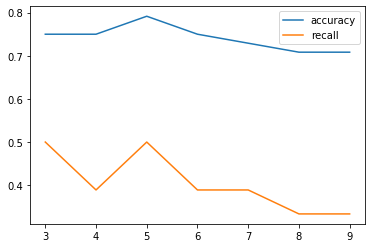

In [1547]:
# Selecting the right hyperparameter

accuracyscores = []
recallscores = []

for neighbors in range(3,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors, metric='minkowski')
    knn.fit(X_train, y_train)
    y_validation_pred = knn.predict(X_validation)
    accuracyscores.append(accuracy_score(y_validation, y_validation_pred))
    recallscores.append(recall_score(y_validation, y_validation_pred))

plt.plot(list(range(3,10)), accuracyscores, label='accuracy')
plt.plot(list(range(3,10)), recallscores, label='recall')
plt.legend()

n_neighbors = 3 has the highest accuracy and recall.

In [1548]:
# KNN and performance analysis

knn = KNeighborsClassifier(n_neighbors=5)

# # cross validation
# scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')

# # cross val score is not used to arrive at a final model but to evaluate the models mean performance using small amount
# # of data so that different estimators can be compared better.
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# fit the model on training data
knn.fit(X_train, y_train)

# Predict the values for validation data
y_validation_pred = knn.predict(X_validation)

# confusion matrix for validation data predictions
print('Confusion matrix for validation data:' '\n', confusion_matrix(y_validation, y_validation_pred))

# accuracy score for validation data predictions 
acc_score = accuracy_score(y_validation, y_validation_pred)
print('Accuracy score for validation data:', acc_score)
      
# precision score for validation data predictions 
pre_score = precision_score(y_validation, y_validation_pred)
print('Precision score for validation data:', pre_score)
      
# recall score for validation data predictions 
rec_score = recall_score(y_validation, y_validation_pred)
print('Recall score for validation data:', rec_score)

accu_scores.append(acc_score)
rec_scores.append(rec_score)

Confusion matrix for validation data:
 [[29  1]
 [ 9  9]]
Accuracy score for validation data: 0.7916666666666666
Precision score for validation data: 0.9
Recall score for validation data: 0.5


##### Decision tree

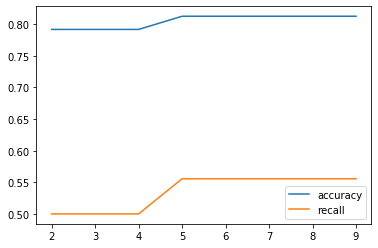

In [1549]:
# Selecting the right hyperparameter

accuracyscores = []
recallscores = []

for leaves in range(2,10):
    dt = DecisionTreeClassifier(max_leaf_nodes = leaves, random_state=0, criterion='entropy')
    dt.fit(X_train, y_train)
    y_validation_pred = dt.predict(X_validation)
    accuracyscores.append(accuracy_score(y_validation, y_validation_pred))
    recallscores.append(recall_score(y_validation, y_validation_pred))

plt.plot(list(range(2,10)), accuracyscores, label='accuracy')
plt.plot(list(range(2,10)), recallscores, label='recall')
plt.legend()

leaves = 2 has high accuracy but low recall. leaves = 9 is perfect.

In [1551]:
# Decision tree and performance analysis

dt = DecisionTreeClassifier(max_leaf_nodes = 5, random_state=0, criterion='entropy')

# # cross validation
# scores = cross_val_score(dt, X_train, y_train, cv=3, scoring='accuracy')

# # cross val score is not used to arrive at a final model but to evaluate the models mean performance using small amount
# # of data so that different estimators can be compared better.
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# fit the model on training data
dt.fit(X_train, y_train)

# Predict the values for validation data
y_validation_pred = dt.predict(X_validation)

# confusion matrix for validation data predictions
print('Confusion matrix for validation data:' '\n', confusion_matrix(y_validation, y_validation_pred))

# accuracy score for validation data predictions 
acc_score = accuracy_score(y_validation, y_validation_pred)
print('Accuracy score for validation data:', acc_score)
      
# precision score for validation data predictions 
pre_score = precision_score(y_validation, y_validation_pred)
print('Precision score for validation data:', pre_score)
      
# recall score for validation data predictions 
rec_score = recall_score(y_validation, y_validation_pred)
print('Recall score for validation data:', rec_score)

accu_scores.append(acc_score)
rec_scores.append(rec_score)

Confusion matrix for validation data:
 [[29  1]
 [ 8 10]]
Accuracy score for validation data: 0.8125
Precision score for validation data: 0.9090909090909091
Recall score for validation data: 0.5555555555555556


##### Random forest

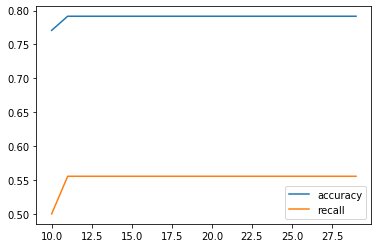

In [1552]:
# Selecting the right hyperparameter

accuracyscores = []
recallscores = []

for estimators in range(10,30):
    rf = RandomForestClassifier(n_estimators = estimators, random_state=0, criterion='entropy')
    rf.fit(X_train, y_train)
    y_validation_pred = rf.predict(X_validation)
    accuracyscores.append(accuracy_score(y_validation, y_validation_pred))
    recallscores.append(recall_score(y_validation, y_validation_pred))

plt.plot(list(range(10,30)), accuracyscores, label='accuracy')
plt.plot(list(range(10,30)), recallscores, label='recall')
plt.legend()

In [1553]:
# Random forest and performance analysis

rf = RandomForestClassifier(n_estimators = 11, random_state=0, criterion='entropy')

# # cross validation
# scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy')

# # cross val score is not used to arrive at a final model but to evaluate the models mean performance using small amount
# # of data so that different estimators can be compared better.
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# fit the model on training data
rf.fit(X_train, y_train)

# Predict the values for validation data
y_validation_pred = rf.predict(X_validation)

# confusion matrix for validation data predictions
print('Confusion matrix for validation data:' '\n', confusion_matrix(y_validation, y_validation_pred))

# accuracy score for validation data predictions 
acc_score = accuracy_score(y_validation, y_validation_pred)
print('Accuracy score for validation data:', acc_score)
      
# precision score for validation data predictions 
pre_score = precision_score(y_validation, y_validation_pred)
print('Precision score for validation data:', pre_score)
      
# recall score for validation data predictions 
rec_score = recall_score(y_validation, y_validation_pred)
print('Recall score for validation data:', rec_score)

accu_scores.append(acc_score)
rec_scores.append(rec_score)

Confusion matrix for validation data:
 [[28  2]
 [ 8 10]]
Accuracy score for validation data: 0.7916666666666666
Precision score for validation data: 0.8333333333333334
Recall score for validation data: 0.5555555555555556


(array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85]),
 <a list of 10 Text yticklabel objects>)

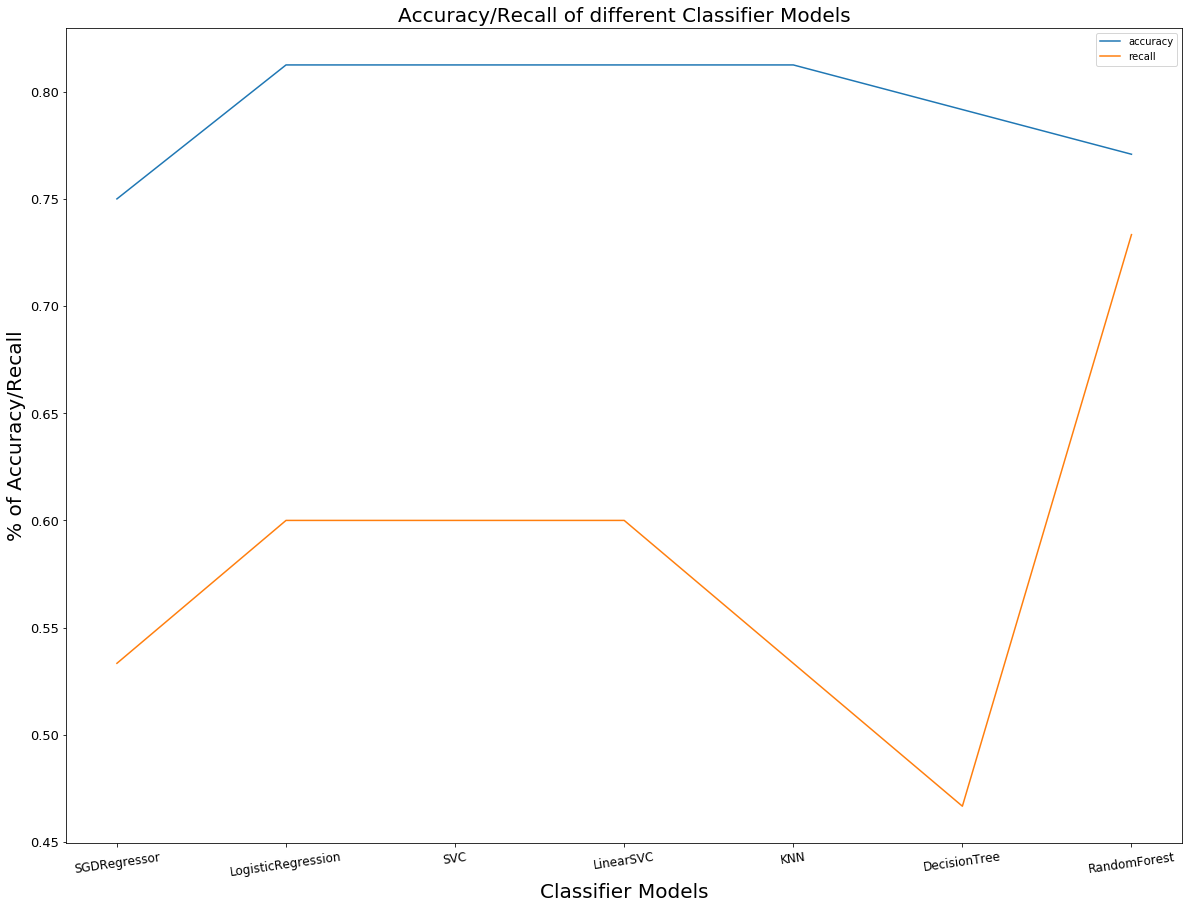

In [1473]:
List = ['SGDRegressor', 'LogisticRegression', 'SVC', 'LinearSVC', 'KNN', 'DecisionTree', 'RandomForest']

plt.figure(figsize=(20,15))
plt.plot(List, accu_scores, label='accuracy')
plt.plot(List, rec_scores, label='recall')
plt.legend()

plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of Accuracy/Recall", fontsize = 20)
plt.title("Accuracy/Recall of different Classifier Models", fontsize = 20)

plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)

2 models are best here. if we evaluate only on basis of accuracy, KNN is best. However, since recall is important here too, SVC which has very high recall and moderately high accuracy is also a close competitor. Let us which of the 2 gives better results. 

In [1474]:
# preparing the test data

X_test = df_test.copy()[['time', 'ejection_fraction', 'serum_creatinine', 'age', 'serum_sodium']]
X_test = scaler.fit_transform(X_test)

#scaler = StandardScaler()
#X_test = scaler.fit_transform(X_train)

y_test = df_test['DEATH_EVENT']

In [1475]:
# predict test values using rf

# predict y values
y_test_pred = rf.predict(X_test)

# confusion matrix for test data predictions
print('Confusion matrix for test data:' '\n', confusion_matrix(y_test, y_test_pred))

# accuracy score for test data predictions 
print('Accuracy score for test data:', accuracy_score(y_test, y_test_pred))
      
# precision score for test data predictions 
print('Precision score for test data:', precision_score(y_test, y_test_pred))
      
# recall score for test data predictions 
print('Recall score for test data:', recall_score(y_test, y_test_pred))

Confusion matrix for test data:
 [[39  2]
 [ 3 16]]
Accuracy score for test data: 0.9166666666666666
Precision score for test data: 0.8888888888888888
Recall score for test data: 0.8421052631578947


In [1040]:
# predict test values using knn 

# predict y values
y_test_pred = knn.predict(X_test)

# confusion matrix for test data predictions
print('Confusion matrix for test data:' '\n', confusion_matrix(y_test, y_test_pred))

# accuracy score for test data predictions 
print('Accuracy score for test data:', accuracy_score(y_test, y_test_pred))
      
# precision score for test data predictions 
print('Precision score for test data:', precision_score(y_test, y_test_pred))
      
# recall score for test data predictions 
print('Recall score for test data:', recall_score(y_test, y_test_pred))

Confusion matrix for test data:
 [[34  1]
 [15 10]]
Accuracy score for test data: 0.7333333333333333
Precision score for test data: 0.9090909090909091
Recall score for test data: 0.4


#### Precision recall tradeoff 
Here, recall will be more important than precision

In [863]:
# Calculating the decision scores for sgdclassifier
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method='decision_function')

In [864]:
# precisions, recalls for all thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

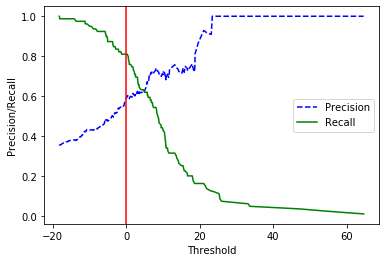

In [865]:
# plot precisions and recalls as function of threshold value 
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend()
plt.ylabel('Precision/Recall')
plt.xlabel('Threshold')
plt.axvline(x=0, color='r')

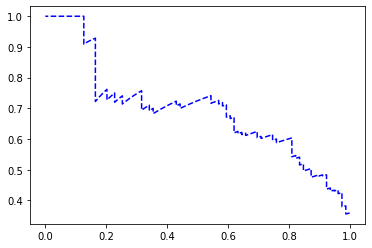

In [866]:
# plot precisions against recalls 
plt.plot(recalls, precisions, "b--")

In [867]:
# find the threshold that will give me 90% recall
threshold_90_recall = thresholds[np.argmax(recalls >= 0.90)]
threshold_90_recall

-18.22609258083933

In [868]:
y_train_pred_90 = y_scores >= threshold_90_recall

In [869]:
recall_score(y_train, y_train_pred_90)

1.0

Will have to explore how to set custom threshold values for a classifier.

In [875]:
confusion_matrix(y_train, y_train_pred_90)

array([[ 19, 141],
       [  0,  79]], dtype=int64)

In search of high recall, the number of false positives increases by a large amount. From a business pov, this will put undue
pressure on medical budget. 